In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 24 16:20:33 2021
@author: mbaxszlh
"""
import torch
from torch import nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os 
from skimage.morphology import skeletonize
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image as imwrite
#import itertools
#from skimage.morphology import skeletonize
from torch.autograd import Variable
from copy import deepcopy
from scipy import signal
import PIL.Image as PIL_Image

import tensorflow as tf

import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import time
# from tqdm import tqdm

In [2]:
from cpumodel import *

In [12]:
def main(folder, train_data, test_data, epoch=150, parallel_num=3, angle_num=4, k_size=9, lambda_=0.1, warm_up=False, identical_init=True, l2_norm=True, return_model=True, resume=False):
    lr_resume = 0
    if resume and lr_resume<0:
        raise ValueError('Please give lr resume value.')
    if not resume and lr_resume!=0:
        print('Please restore lr resume value.')
        lr_resume = 0
        
    print('task: '+folder)

    batch_size = 32
    volume = len(train_data) + len(test_data)
    print('training volume: ', volume)
    train_data = WrappedDataLoader(get_data(train_data, batch_size), preprocess)
    test_data = WrappedDataLoader(get_data(test_data, batch_size), preprocess)
    
    if not resume:
        model = MASC_Model(angle_num, parallel_num, k_size, identical=identical_init)
        torch.save(model, folder + '/init_model')
    else:
        model = torch.load(folder+'/model')
        
    torch.save(model, folder + '/init_model')
    print('model parameters: ', get_n_params(model))
    if model.MASC_Block1.MAC.messageIntegration in ['cosine', 'diffCosine']:
        print('GConv Block2 b2: '+str(model.MASC_Block1.MAC.b2[0].data))
    loss_func = nn.BCELoss()
    loss_func2 = nn.BCELoss()
    # loss_func2 = nn.MSELoss()
    if resume:
        opt = torch.optim.Adam(model.parameters(), lr = 0.001*(0.5**lr_resume))
    else:
        opt = torch.optim.Adam(model.parameters(), lr = 0.001)
    
    img = cv2.imread('data/testset/Image_11L.jpg')
    img = cv2.resize(img,None,fx=0.5,fy=0.5)
    img = torch.from_numpy(img)
    img = img.transpose(0, 2).transpose(1, 2)
    img = img.view(1, *img.shape).float()
    img, ori_h, ori_w = code_testimg(img)
    
    
    #train
    loss_recorder, model = fit(model, epoch, loss_func, loss_func2, lambda_, opt, train_data ,test_data, folder, img, warm_up=warm_up, l2_norm=l2_norm, resume=resume)
    if model.MASC_Block1.MAC.messageIntegration in ['cosine', 'diffCosine']:
        # print('MASC_Block1 b2: '+str(model.GC_Block1.GConv.b2[0].data))
        print('MASC_Block1 b2: '+str(model.MASC_Block1.MAC.b2[0].data))
    torch.save(model, folder + '/model')
    np.save(folder + '/log', loss_recorder)
    
    a = model(img, l2_norm)
    index = 0
    for i in a[1:4]:
        pmap = to_array(i)[0, 0]
        pmap = 255*(pmap/pmap.max())
        cv2.imwrite(folder + '/pmap'+str(index)+'.png', pmap)
        index += 1
    index = 0
    for i in a[4]:
        cv2.imwrite(folder+'/index'+str(index)+'_ep'+str(epoch)+'.png', to_array(i[0,0]))
        index += 1
    imwrite(a[0][0,0]//1, folder + '/out.png') 

    test_list = os.listdir('data/testset/')
    os.system("mkdir "+folder+"/test")
    for i in test_list:
        print(i)
        img = cv2.imread('data/testset/'+i)[:, :992]
        img = cv2.resize(img,None,fx=0.5,fy=0.5)
        img = torch.from_numpy(img)
        img = img.transpose(0, 2).transpose(1, 2)
        img = img.view(1, *img.shape).float()
        img, ori_h, ori_w = code_testimg(img)
        img = to_array(uncode_testimg(model(img, l2_norm)[0], ori_h, ori_w)[0, 0]*255)
        cv2.imwrite(folder+'/test/'+i, img)
    if return_model == True:
        return model
    else:
        return 
# Set hyper-parameters
num_fold = 5
parallel_num = 2
k_size = 9
# theta in [0, 2pi)
angle_num = 16
# model = MASC_Model(angle_num, parallel_num, k_size, identical=True)

# model
# webhook_url = "https://discord.com/api/webhooks/1092697857074679859/O9iUUlWNh5WOjgYOUii-v7TN1IlzjuSb5Nc29Sho0_luHYWH3hLNS39b1qUUaPRMiuFh"

# @discord_sender(webhook_url = webhook_url)
# def test():
for fold in range(num_fold):
    os.system('mkdir models/MASC_p{}a{}k{}l2_fold{}'.format(parallel_num, angle_num, k_size, fold))

    # Load all data
    img = np.load('data/training_img.npy')
    label = np.load('data/training_label.npy')
    img2 = np.load('data/testing_img.npy')
    label2 = np.load('data/testing_label.npy')
    all_img = np.concatenate((img, img2))
    all_label = np.concatenate((label, label2))
    
    all_img = all_img[::40]
    all_label = all_label[::40]
    
    # Cross validation
    sample_num = len(all_img)
    mask = np.zeros(sample_num).astype(int)
    bin_num = sample_num//num_fold
    mask[fold*bin_num:(fold+1)*bin_num]
    img = all_img[mask].astype(int)
    label = all_label[mask]
    img2 = all_img[~mask]
    label2 = all_label[~mask]

    # Wrap data
    x_data, y_data = map(torch.tensor, (img, label))
    x_data = x_data.type('torch.FloatTensor')
    y_data = y_data.type('torch.FloatTensor')
    trainset = TensorDataset(x_data, y_data)
    
    x_data, y_data = map(torch.tensor, (img2, label2))
    x_data = x_data.type('torch.FloatTensor')
    y_data = y_data.type('torch.FloatTensor')
    testset = TensorDataset(x_data, y_data)
    
    # Train model
    Reg_mode = 3
    # temp = main('5MASC/temp', trainset, testset, epoch=3, parallel_num=2, angle_num=8, k_size=5, warm_up=True, identical_init=True, l2_norm=True, return_model=True)
    
    model = main('models/MASC_p{}a{}k{}l2_fold{}'.format(parallel_num, angle_num, k_size, fold), trainset, testset, epoch=5, parallel_num=parallel_num, angle_num=angle_num, k_size=k_size, lambda_=0.01, warm_up=False, identical_init=True, l2_norm=True, return_model=True,resume=False)
# test()

task: models/MASC_p2a16k9l2_fold0
training volume:  200
model parameters:  5924
GConv Block2 b2: tensor([-0.9952])
lambda: 0.01
epoch:0	loss:0.71711	0.01*loss_ext:0.00004	time:22.26663
sensitivity 0.5034065842628479
specificity 0.5017093122005463
AUC:  0.44511038064956665
F1 Score: 0.08244670182466507
epoch:1	loss:0.64612	0.01*loss_ext:0.00004	time:19.31525
sensitivity 0.4978571832180023
specificity 0.4915440082550049
AUC:  0.5192843675613403
F1 Score: 0.06586707383394241
epoch:2	loss:0.61636	0.01*loss_ext:0.00004	time:19.18803
sensitivity 0.49674510955810547
specificity 0.48992639780044556
AUC:  0.47111350297927856
F1 Score: 0.05377538129687309
epoch:3	loss:0.59649	0.01*loss_ext:0.00005	time:19.59302
sensitivity 0.48834869265556335
specificity 0.5592642724514008
AUC:  0.5059931874275208
F1 Score: 0.06112469360232353
epoch:4	loss:0.58113	0.01*loss_ext:0.00005	time:19.49884
sensitivity 0.49840620160102844
specificity 0.48362988233566284
AUC:  0.512175977230072
F1 Score: 0.07040417194366

In [3]:
model = torch.load("models/MASC_p2a16k9l2_fold4"+'/model')

In [8]:
model.load_state_dict(torch.load('models/MASC_p2a16k9l2_fold4/init_model'))

TypeError: Expected state_dict to be dict-like, got <class 'cpumodel.MASC_Model'>.

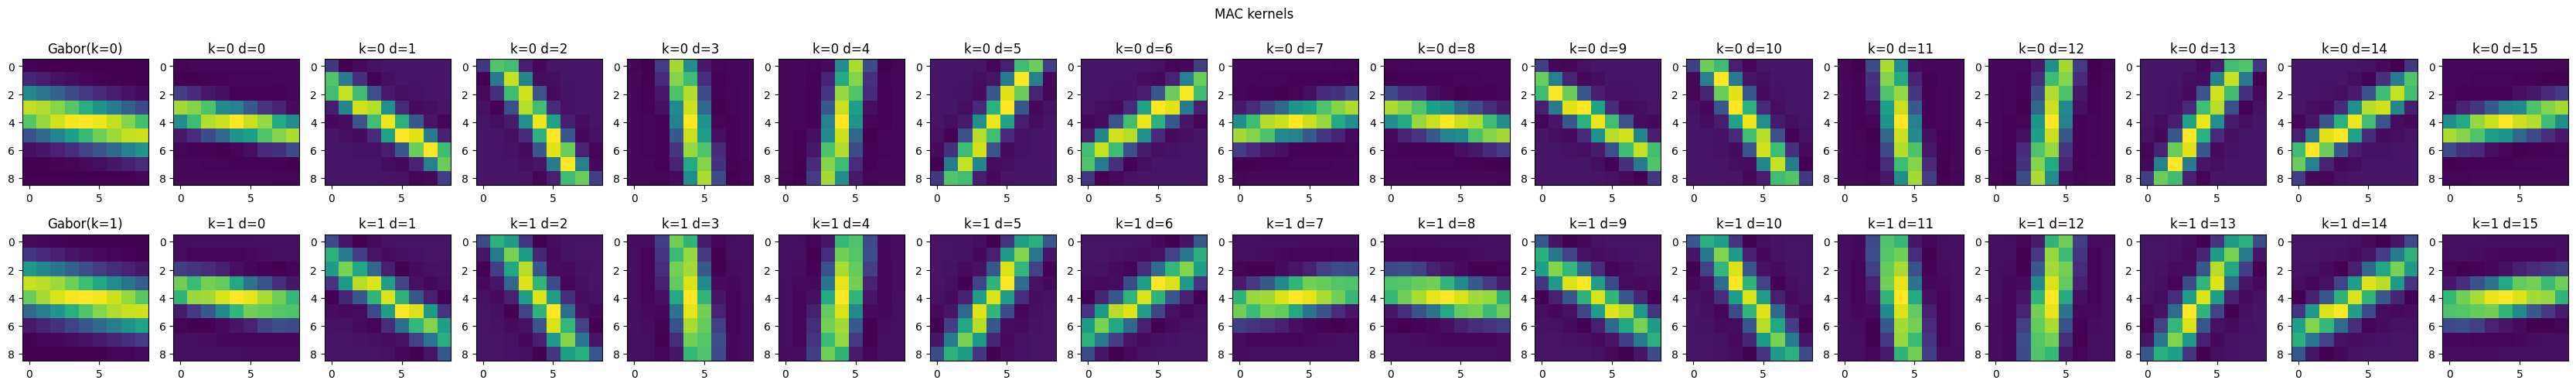

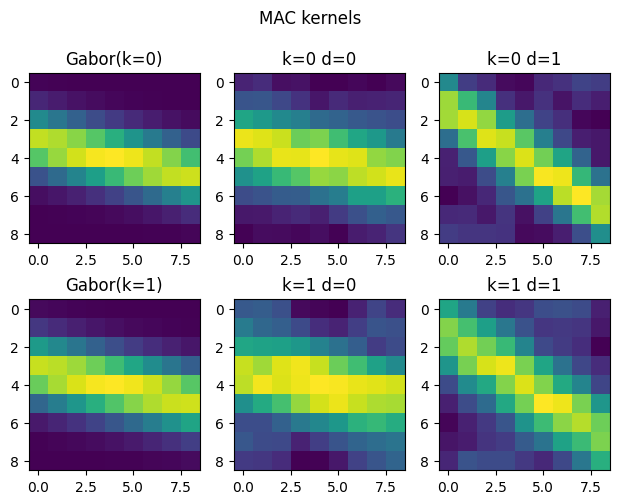

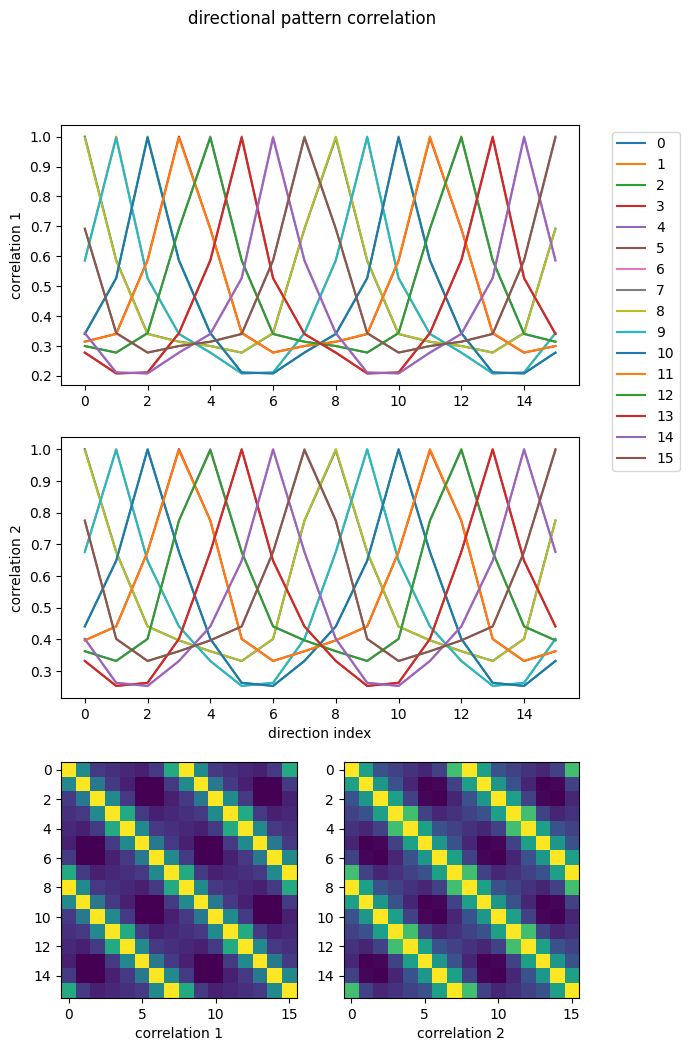

In [5]:
# Visualise model
MAC_visual(model)
convW_visual(model)
correlation_visual(model)


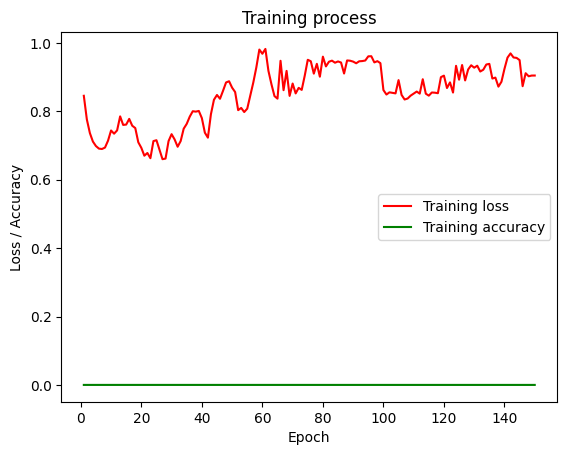

In [6]:
import numpy as np
import matplotlib.pyplot as plt
log_data = np.load('models/MASC_p2a16k9l2_fold4/log.npy')
# log_data
# Access training and validation loss values from log dictionary
train_loss = [x[0] for x in log_data]
train_acc = [x[1] for x in log_data]
epochs = range(1, len(train_loss)+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.title('Training process')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

In [4]:
import numpy as np

log_data = np.load('models/MASC_p2a16k9l2_fold1/log.npy')
# log_data
train_loss = [x[0] for x in log_data]
train_acc = [x[1] for x in log_data]
train_acc

array([[6.0337335e-01, 4.4882454e-05],
       [5.5913734e-01, 4.7412053e-05],
       [5.3060198e-01, 5.0964227e-05],
       [5.1272941e-01, 5.4828364e-05],
       [5.0071317e-01, 5.6451820e-05],
       [4.9866253e-01, 5.5595028e-05],
       [4.9558556e-01, 5.6446537e-05],
       [4.9731985e-01, 5.7900816e-05],
       [5.0020117e-01, 5.9287871e-05],
       [4.9992579e-01, 5.9213442e-05],
       [5.0175071e-01, 6.1324361e-05],
       [4.9951148e-01, 6.4124382e-05],
       [4.9426401e-01, 6.5778193e-05],
       [4.9849439e-01, 6.6684843e-05],
       [4.9964851e-01, 6.8944348e-05],
       [5.0788373e-01, 6.9868132e-05],
       [5.4712570e-01, 7.1614748e-05],
       [5.7367587e-01, 7.5425982e-05],
       [5.6062478e-01, 7.5358417e-05],
       [5.4651606e-01, 7.7925011e-05],
       [5.4708773e-01, 7.8980323e-05],
       [5.3041339e-01, 8.0623591e-05],
       [5.3433633e-01, 8.1696155e-05],
       [5.3113800e-01, 8.3803934e-05],
       [5.4735661e-01, 8.5923697e-05],
       [5.7428479e-01, 8.

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


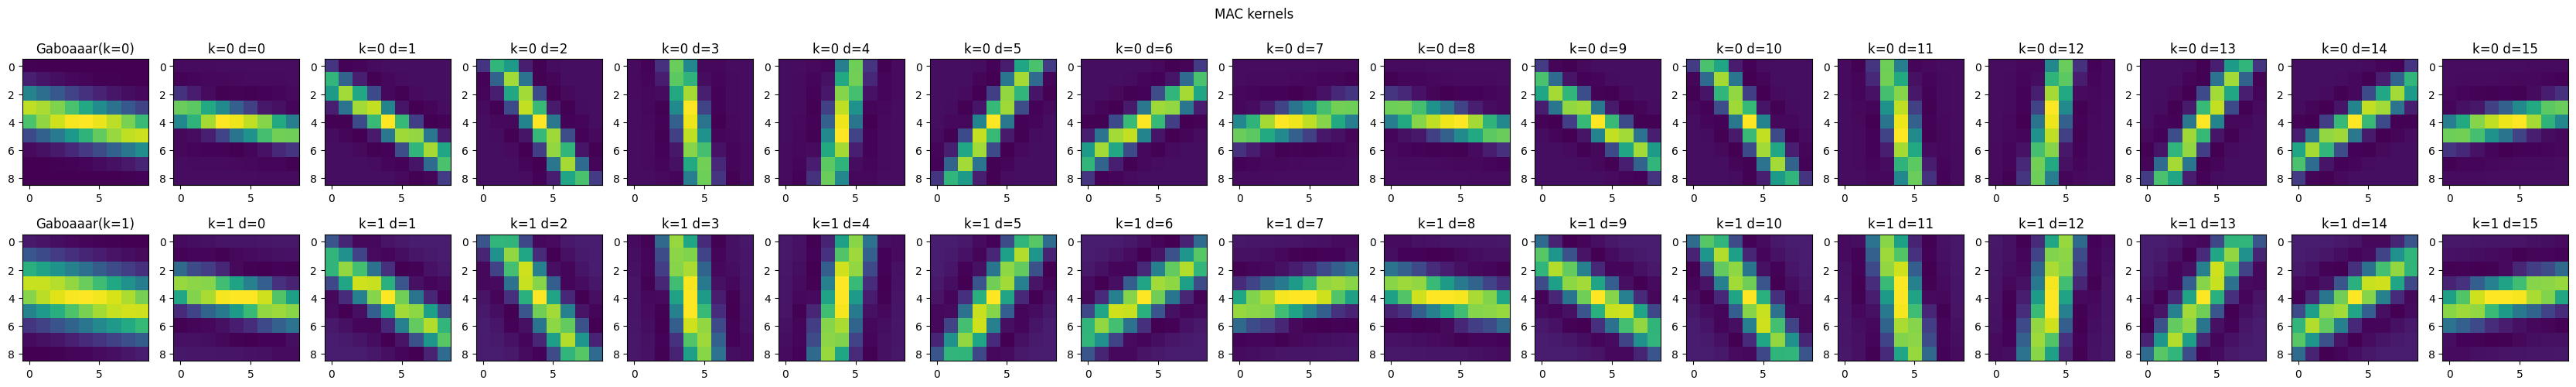

In [1]:
from cpumodel import *

num_fold = 1
parallel_num = 2
k_size = 9
# theta in [0, 2pi)
angle_num = 16
model = MASC_Model(angle_num, parallel_num, k_size, identical=True)
# model
# model
MAC_visual(model)
